In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as np
import time
from pennylane.optimize import AdamOptimizer
import torch
import h5py
from skimage.metrics import structural_similarity as ssim

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = [3, 1]
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

## Settings

In [2]:
nbatch = 3000
N = 3
M = 2
nM = M - 1
qM = int(np.log2(M))
num_dim = 1
num_qubits = int(N**2 * np.log2(M))
num_discrete_values = 2**num_qubits

file_name = "QG_train_normalized_N3_M2_bilinear_large"

reg = 0.000001

## Data

In [3]:
f = h5py.File(file_name,"r")

In [4]:
x_train = f.get('X')
y_train = f.get('y')

(-0.5, 2.5, 2.5, -0.5)

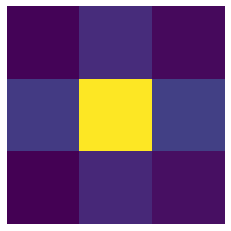

In [5]:
plt.imshow(np.mean(x_train[y_train[:]==1],axis=0),norm=matplotlib.colors.LogNorm())
plt.axis('off')

(-0.5, 2.5, 2.5, -0.5)

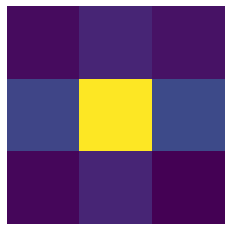

In [6]:
plt.imshow(np.mean(x_train[y_train[:]==0],axis=0),norm=matplotlib.colors.LogNorm())
plt.axis('off')

(-0.5, 2.5, 2.5, -0.5)

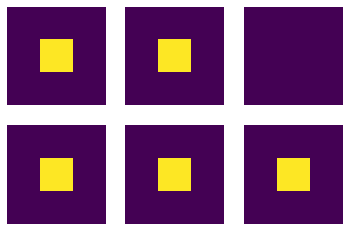

In [7]:
fig, ax = plt.subplots(2, 3)
nums = np.random.randint(0,6,size=(6,))
ax[0,0].imshow(x_train[nums[0]])
ax[0,0].axis('off')
ax[0,1].imshow(x_train[nums[1]])
ax[0,1].axis('off')
ax[0,2].imshow(x_train[nums[2]])
ax[0,2].axis('off')
ax[1,0].imshow(x_train[nums[3]])
ax[1,0].axis('off')
ax[1,1].imshow(x_train[nums[4]])
ax[1,1].axis('off')
ax[1,2].imshow(x_train[nums[5]])
ax[1,2].axis('off')

In [8]:
data = x_train[y_train[:]==1]

In [9]:
f.close()

In [10]:
data.shape

(19969, 3, 3)

In [11]:
sums = np.sum(data,axis=(1,2))

In [12]:
sums.shape

(19969,)

In [13]:
idx = np.where(sums > 0)[0]

In [14]:
len(idx)

12019

In [15]:
data[idx].shape

(12019, 3, 3)

In [16]:
data = data[idx]

In [17]:
data.shape

(12019, 3, 3)

In [18]:
prob_distr = data.reshape(-1,9)

In [19]:
prob_distr[0]

array([0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [20]:
mean_data = np.mean(data,axis=0)

## Utillity functions

In [21]:
def int_to_bin_list(num,bits):
    return [(num>>k)&1 for k in range(0,bits)][::-1]

In [22]:
def convert_dim_to_integer(arr,dim):
    # Calculate the number of possible values 
    num_values = 2 ** arr.shape[dim]
    arr = torch.flip(arr,(1,))
    # Sum along the last dimension to convert it to integers
    integer_array = np.sum(arr * (2 ** np.arange(arr.shape[dim])), axis=-1)

    return torch.tensor(integer_array)

In [23]:
def normalize_image(img):
    return img / nM

In [24]:
def basis_array_to_img(basis_array):
    basis_array = basis_array.reshape(N,N,qM)
    return normalize_image(convert_dim_to_integer(basis_array,2))

In [25]:
def batch_basis_array_to_img(batch_basis_array):
    batch_basis_array = batch_basis_array.reshape(batch_basis_array.shape[0],N,N,qM)
    return normalize_image(convert_dim_to_integer(batch_basis_array,3))

In [26]:
def tensor_to_int(tensor):
    tensor = tensor.long()
    
    # Calculate the number of columns in the tensor
    num_columns = tensor.size(1)
    
    # Create a weight tensor for binary to integer conversion
    weights = 2 ** torch.arange(num_columns - 1, -1, -1)
    
    # Calculate the integer values for each row
    int_values = torch.sum(tensor * weights, dim=1)
    
    return int_values

In [27]:
from IPython.display import clear_output

matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

def plot_training_progress(n, samples_tuple,mean_gen_image):
    # we don't plot if we don't have enough data
    if len(generator_loss_values) < 2:
        return

    clear_output(wait=True)
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(18, 12))
    fig.tight_layout(pad=10.0)

    # Generator Loss
    ax3.plot(generator_loss_values, label="generator loss", color="royalblue")
    ax3.plot(discriminator_loss_values, label="discriminator loss", color="magenta")
    ax3.legend(loc="best", fontsize=16)
    ax3.set_xlabel("epoch", fontsize=16)
    ax3.set_ylabel("Loss", fontsize=16)
    #ax3.grid()

    # Relative Entropy
    ax2.plot(entropies)
    ax2.set_xlabel("epoch", fontsize=18)
    ax2.set_ylabel("KL divergence", fontsize=18)
    ax2.set_yscale("log")
    #ax2.grid()
    
    #paramsg = generator.weights
    #generated_probabilities = circuit(1,paramsg).detach()
    im = ax1.imshow(mean_gen_image, norm=matplotlib.colors.LogNorm())
    plt.colorbar(im,ax=ax1)
    #ax3.grid()
    #plt.savefig(f"imgs/plt-{n}.png")
    
    im2 = ax4.imshow(mean_data, norm=matplotlib.colors.LogNorm())
    plt.colorbar(im2,ax=ax4)
    
    ax5.plot(mses)
    ax5.set_xlabel("epoch", fontsize=18)
    ax5.set_ylabel("MSE", fontsize=18)
    ax5.set_yscale("log")

    plt.show()

In [28]:
def iterate_minibatches(data, batch_size):
    for start_idx in range(0, data.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield data[idxs]

# Model

## Generator circuits

In [29]:
dev = qml.device("default.qubit.torch", wires=num_qubits)

@qml.qnode(dev, interface="torch", diff_method="backprop", cachesize=1000000)
def circuit(inputs, weights):
    #for wire in range(num_qubits): qml.Hadamard(wires=wire)
    qml.StronglyEntanglingLayers(weights=weights, wires=list(range(num_qubits)), imprimitive=qml.ops.CZ)
    return qml.probs()

In [30]:
dev_sample = qml.device("default.qubit", wires=num_qubits, shots=nbatch)

@qml.qnode(dev_sample, interface="torch")
def circuit_sample(inputs, weights):
    #for wire in range(num_qubits): qml.Hadamard(wires=wire)
    qml.StronglyEntanglingLayers(weights=weights, wires=list(range(num_qubits)), imprimitive=qml.ops.CZ)
    return qml.sample()

## Hybrid model building

In [31]:
n_layers=35
weight_shapes = {"weights": (n_layers, num_qubits,3)}

In [32]:
qlayer = qml.qnn.TorchLayer(circuit, weight_shapes)

In [33]:
from torch import nn

class Discriminator(nn.Module):
    def __init__(self, input_size):
        super(Discriminator, self).__init__()

        self.linear_input = nn.Linear(input_size, 50)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.linear1 = nn.Linear(50, 20)
        self.linear2 = nn.Linear(20, 10)
        self.linear3 = nn.Linear(10, 1)
        self.sigmoid = nn.Sigmoid()
        self.flatten = nn.Flatten()

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        x = self.flatten(input)
        x = self.linear_input(x)
        x = self.leaky_relu(x)
        x = self.linear1(x)
        x = self.leaky_relu(x)
        x = self.linear2(x)
        x = self.leaky_relu(x)
        x = self.linear3(x)
        x = self.sigmoid(x)
        return x

In [34]:
generator = qlayer
discriminator = Discriminator(N**2)

# Training

In [35]:
prob_distr_nums = convert_dim_to_integer(torch.tensor(prob_distr),1)

In [36]:
vals, counts = np.unique(prob_distr_nums, return_counts=True)

In [37]:
counts_full = np.zeros(num_discrete_values)

In [38]:
counts_full[vals.astype(int)] = counts

In [39]:
counts_full_norm = counts_full / prob_distr_nums.shape[0]

In [40]:
from torch.optim import Adam

lr = 0.001  # learning rate
#b1 = 0.7  # first momentum parameter
b1 = 0.6  # first momentum parameter
b2 = 0.999  # second momentum parameter

generator_optimizer = Adam(generator.parameters(), lr=lr, betas=(b1, b2), weight_decay=0, amsgrad=True)
discriminator_optimizer = Adam(
    discriminator.parameters(), lr=lr, betas=(b1, b2), weight_decay=0, amsgrad=True
)

decayRate = 0.999
my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=generator_optimizer, gamma=decayRate)

In [41]:
def adversarial_loss(inputs, target, w):
    bce_loss = target * torch.log(inputs) + (1 - target) * torch.log(1 - inputs)
    weighted_loss = w * bce_loss
    total_loss = -torch.sum(weighted_loss)
    return total_loss

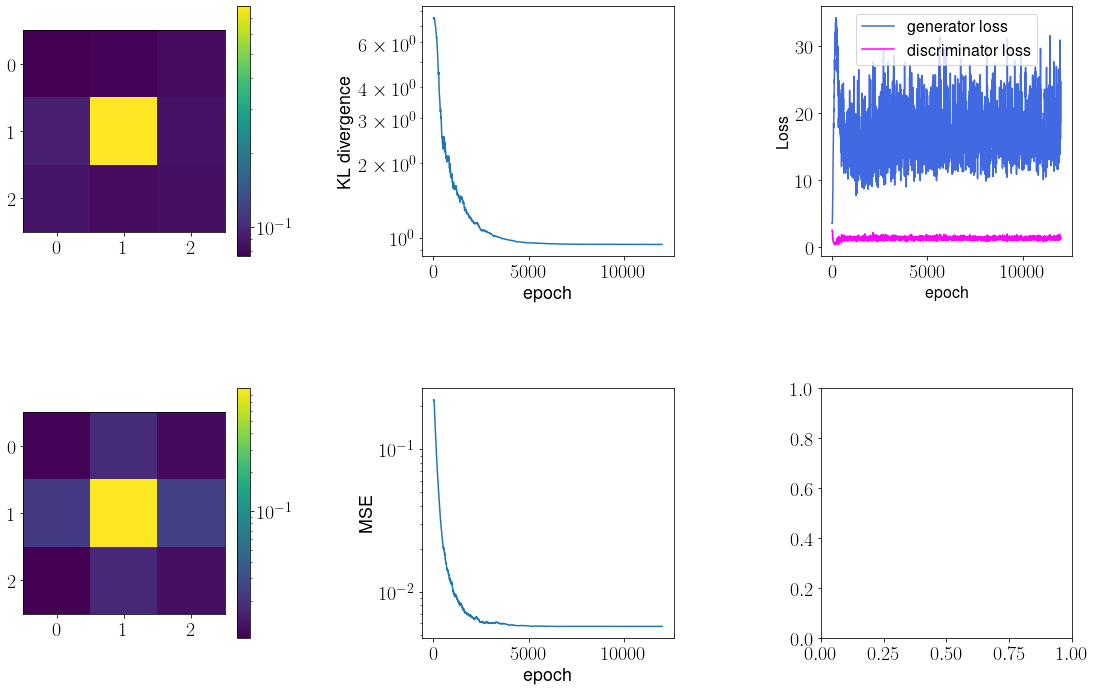

Fit in 78905.09 sec


In [42]:
import time
from scipy.stats import multivariate_normal, entropy

torch.nn.init.uniform_(list(generator.parameters())[0], a=-np.pi, b=np.pi)
#torch.nn.init.uniform_(list(generator.parameters())[0], a=-0.1, b=0.1)

n_epochs = 3000

data = torch.tensor(data, requires_grad=False)

generator_loss_values = []
discriminator_loss_values = []
entropies = []
mses = []

start = time.time()
for epoch in range(n_epochs):

    valid = torch.ones(nbatch, dtype=torch.float)
    fake = torch.zeros(nbatch, dtype=torch.float)

    #samples = circuit_sample(1, list(generator.parameters())[0].detach()).float()
    #samples = torch.tensor(np.random.randint(0,16, size=(nbatch,)), dtype=torch.float).reshape(nbatch,1)
    samples = torch.tensor(np.random.randint(0,2,size=(nbatch,num_qubits)), dtype=torch.float)
    samples_idx = convert_dim_to_integer(samples,1)
    samples_img = batch_basis_array_to_img(samples)
    
    #samples = samples.float().reshape(-1,1)
    
    for j,Xbatch in enumerate(iterate_minibatches(data, batch_size=nbatch)):
 
        # discriminator values
        disc_value = discriminator(samples_img.float())
    
        # gen dist
        gen_dist = generator(torch.tensor([]))
        
        # Train generator
        generator_optimizer.zero_grad()
        generator_loss = adversarial_loss(disc_value.detach().reshape(-1)+reg, valid, gen_dist[samples_idx.long().reshape(-1)])
        
        # store for plotting
        generator_loss_values.append(generator_loss.detach().item())

        generator_loss.backward(retain_graph=True)
        generator_optimizer.step()

        # Train Discriminator
        discriminator_optimizer.zero_grad()
     
        real_disc_vals = discriminator(Xbatch.float())
    
        real_loss = adversarial_loss(real_disc_vals.reshape(-1)+reg, valid, torch.tensor(np.ones(nbatch)*1/nbatch, requires_grad=False))
        fake_loss = adversarial_loss(disc_value.reshape(-1)+reg, fake, gen_dist.detach()[samples_idx.long().reshape(-1)])
        discriminator_loss = (real_loss + fake_loss) / 2    
        
        # Store for plotting
        discriminator_loss_values.append(discriminator_loss.detach().item())
    
        discriminator_loss.backward()
        discriminator_optimizer.step()
        
        mean_gen_image = torch.sum(gen_dist.detach().squeeze().reshape(-1,1,1)*batch_basis_array_to_img(torch.tensor([int_to_bin_list(x,num_qubits) for x in range(2**num_qubits)])),0)
        
        
        entropy_val = entropy(gen_dist.detach()+0.000001, counts_full_norm+0.000001)
        entropies.append(entropy_val)
        
        mse_val = np.mean((mean_gen_image.numpy()-mean_data)**2)
        mses.append(mse_val)
        
        my_lr_scheduler.step()

        plot_training_progress(epoch, (samples,),mean_gen_image)
        
elapsed = time.time() - start
print(f"Fit in {elapsed:0.2f} sec")

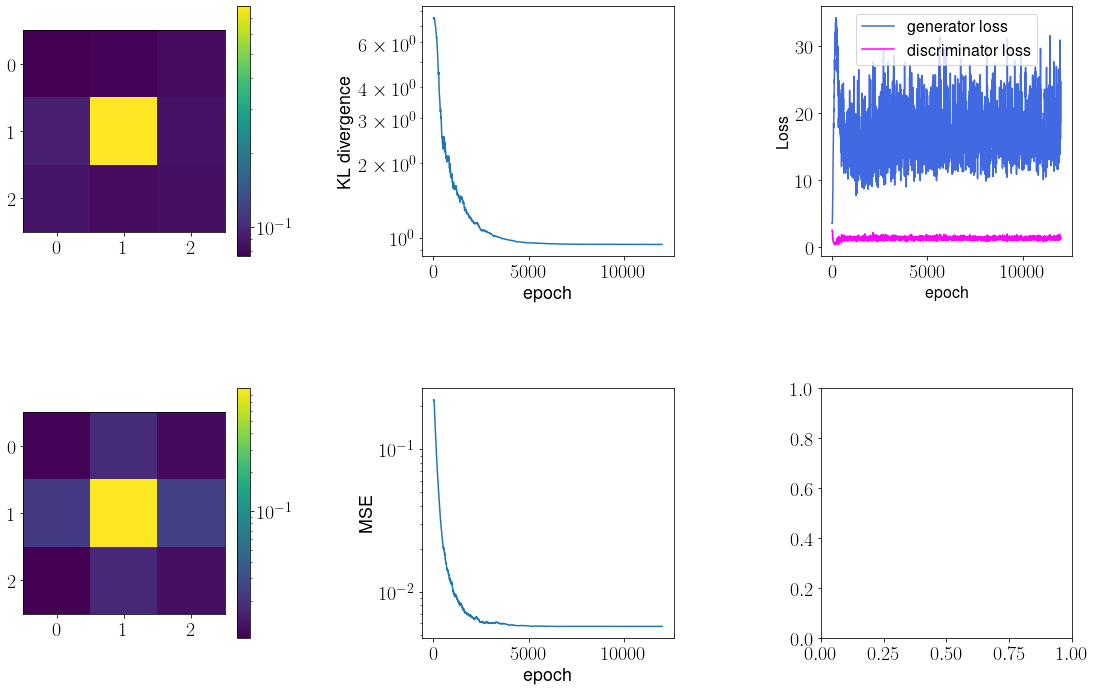

In [43]:
plot_training_progress(epoch, (samples,),mean_gen_image)

In [44]:
torch.sum(mean_gen_image)

tensor(1.4515)

In [45]:
counts_full_norm

tensor([0.00000000e+00, 9.65138531e-03, 1.32290540e-02, 1.66403195e-04,
        8.32015975e-03, 8.32015975e-05, 0.00000000e+00, 0.00000000e+00,
        1.78883435e-02, 1.66403195e-04, 2.49604792e-04, 0.00000000e+00,
        8.32015975e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        8.75780015e-01, 1.91363674e-03, 3.41126550e-03, 0.00000000e+00,
        1.58083035e-03, 8.32015975e-05, 8.32015975e-05, 0.00000000e+00,
        4.65928946e-03, 8.32015975e-05, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.71395291e-02, 8.32015975e-05, 1.66403195e-04, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        3.32806390e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        4.32648307e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.000000

In [46]:
circuit(1, list(generator.parameters())[0].detach())

tensor([1.3033e-02, 9.7224e-03, 1.0834e-02, 4.1518e-04, 1.6682e-02, 6.2980e-04,
        2.7486e-04, 2.9849e-04, 1.1631e-02, 3.1378e-03, 2.2686e-03, 1.6198e-04,
        8.4491e-04, 2.7099e-05, 5.5342e-04, 6.0211e-04, 6.8625e-01, 4.3419e-03,
        3.6349e-03, 5.0258e-04, 1.3472e-04, 1.8724e-04, 4.8966e-04, 4.3716e-04,
        2.3718e-03, 2.7486e-03, 1.5272e-03, 3.3830e-04, 7.2378e-04, 8.1218e-04,
        9.3835e-05, 1.8386e-04, 2.3034e-02, 1.1392e-03, 1.3509e-03, 4.0460e-04,
        2.2736e-03, 3.4650e-04, 4.9777e-04, 2.7999e-04, 1.6624e-03, 3.0971e-04,
        4.5225e-04, 4.0202e-04, 4.7910e-05, 9.3352e-05, 6.8104e-05, 2.6998e-05,
        2.9684e-03, 3.6798e-04, 2.0212e-03, 2.1767e-05, 2.4185e-04, 7.9084e-05,
        1.1862e-04, 1.5808e-04, 1.0415e-03, 4.2848e-04, 2.9999e-04, 6.0979e-05,
        9.7719e-04, 1.3874e-04, 1.7853e-05, 2.1209e-04, 9.0643e-03, 1.0376e-03,
        6.7114e-04, 6.5953e-04, 1.5494e-03, 3.7441e-04, 4.2905e-04, 3.7811e-04,
        2.5998e-03, 6.0936e-04, 1.3654e-

In [47]:
basis_array_to_img(circuit_sample(1, list(generator.parameters())[0].detach())[0])

tensor([[0., 0., 0.],
        [0., 1., 0.],
        [0., 0., 0.]])

In [48]:
batch_basis_array_to_img(torch.tensor([int_to_bin_list(x,num_qubits) for x in range(2**num_qubits)])).shape

torch.Size([512, 3, 3])